In [1]:
import functools
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split as _train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_union
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
sns.set_theme()

# Building preprocessing pipeline

## Download CSV data

In [4]:
SHEET_ID = '1eb-NV5o-ed9DgS-tQuG_hL_MHVRaUKB1uT_889Uhg2k'
SHEET_NAME = 'test'
DOWNLOAD_URL = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'

In [5]:
def download_dataset(download_url):    
    trips = pd.read_csv(download_url, parse_dates=['calc_created'])
    
    return trips

In [6]:
trips = download_dataset(DOWNLOAD_URL)

In [7]:
trips.head()

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,...,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 03:37:31,4.04,10.0,2839,700,1,client,finished,...,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 02:26:19,6.09,3.6,5698,493,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0
3,313,313,2020-02-05 06:34:54,72871.72,NaN,49748,1400,0,client,finished,...,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN
4,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,...,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN


__For convenience only, we take logarithm of the next columns.__

In [8]:
LOGCOLS = ['upfront_price', 'metered_price', 'predicted_distance', 'predicted_duration']

In [9]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, logcols):
        self.logcols = logcols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X.loc[:, self.logcols] = np.log(X[self.logcols])
        
        return X

In [10]:
trips = LogTransformer(LOGCOLS).transform(trips)

Text(0, 0.5, 'log(metered_price)')

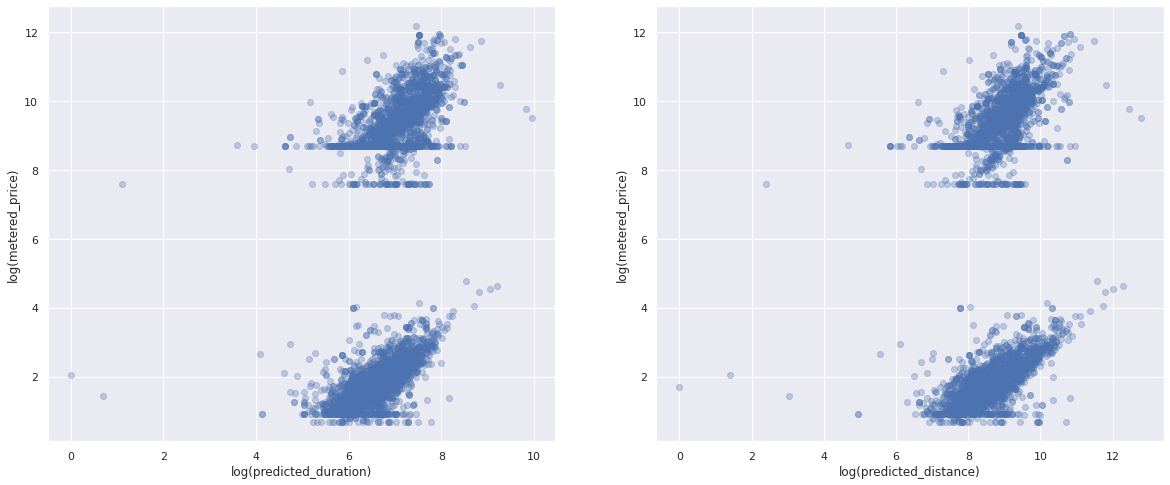

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['predicted_duration'], trips['metered_price'], alpha=0.3)
ax[0].set_xlabel('log(predicted_duration)')
ax[0].set_ylabel('log(metered_price)')
ax[1].scatter(trips['predicted_distance'], trips['metered_price'], alpha=0.3)
ax[1].set_xlabel('log(predicted_distance)')
ax[1].set_ylabel('log(metered_price)')

I would recommend you [this](https://chart-studio.plotly.com/create/?fid=plotly2_demo:437#/) to build 3D interactive model.

/tmp/ipykernel_69676/806850964.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


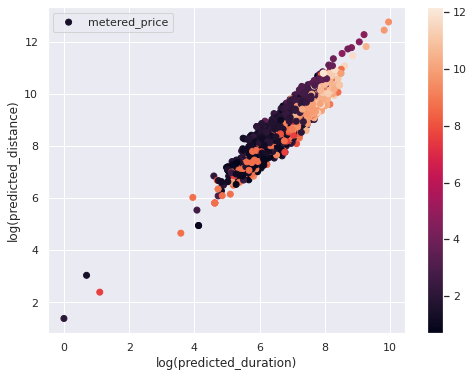

In [12]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(trips['predicted_duration'], 
            trips['predicted_distance'], 
            c=trips['metered_price'], 
            label='metered_price')
plt.xlabel('log(predicted_duration)')
plt.ylabel('log(predicted_distance)')
plt.colorbar()
plt.legend()

## Clean up the data

In [13]:
trips.describe()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,predicted_distance,predicted_duration,ticket_id_new,device_token,driver_device_uid_new,eu_indicator,overpaid_ride_ticket,fraud_score
count,4943.000000,4943.000000,4923.000000,3409.000000,4943.000000,4943.000000,4943.000000,4943.000000,4923.000000,4923.000000,4943.000000,0.0,4943.000000,4943.000000,4943.000000,2184.000000
mean,2061.074449,2061.074044,5.186442,3.680963,9769.223144,1566.230629,0.800728,1.119361,-inf,-inf,2471.000000,NaN,1093.311349,0.560388,0.068177,-674.046703
std,1199.298429,1199.299081,3.857424,3.402727,10912.426401,1650.329858,0.399493,0.499611,NaN,NaN,1427.065521,NaN,626.408069,0.496390,0.252075,1119.189890
min,0.000000,0.000000,0.693147,0.693147,0.000000,0.000000,0.000000,1.000000,-inf,-inf,0.000000,NaN,0.000000,0.000000,0.000000,-14225.000000
25%,1020.500000,1020.500000,1.682688,1.435085,3785.500000,604.000000,1.000000,1.000000,8.326154,6.392754,1235.500000,NaN,561.500000,0.000000,0.000000,-826.500000
50%,2065.000000,2065.000000,2.591516,1.887070,7140.000000,1054.000000,1.000000,1.000000,8.841882,6.844815,2471.000000,NaN,1088.000000,1.000000,0.000000,-278.500000
75%,3090.500000,3090.500000,9.304893,8.294050,11953.000000,1929.500000,1.000000,1.000000,9.275566,7.263330,3706.500000,NaN,1643.000000,1.000000,0.000000,-64.750000
max,4165.000000,4165.000000,12.178103,13.296317,233190.000000,22402.000000,1.000000,12.000000,12.775746,9.951897,4942.000000,NaN,2158.000000,1.000000,1.000000,49.000000


In [14]:
class CleanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        cond = X['metered_price'].notna()  #  drop NaN from metered_price
        cond &= X['predicted_distance'] > 0  #  predicted_distance has to be positive
        cond &= X['predicted_duration'] > 0  #  predicted_duration has to be positive
        
        X.loc[:, 'change_reason_pricing'] = X['change_reason_pricing'].fillna('NONE')
        
        X = X.loc[cond]
        
        return X

In [15]:
trips = CleanTransformer().transform(trips)

## Add additional features

In [16]:
mask = trips['metered_price'].isin(np.log([2000, 6000]))

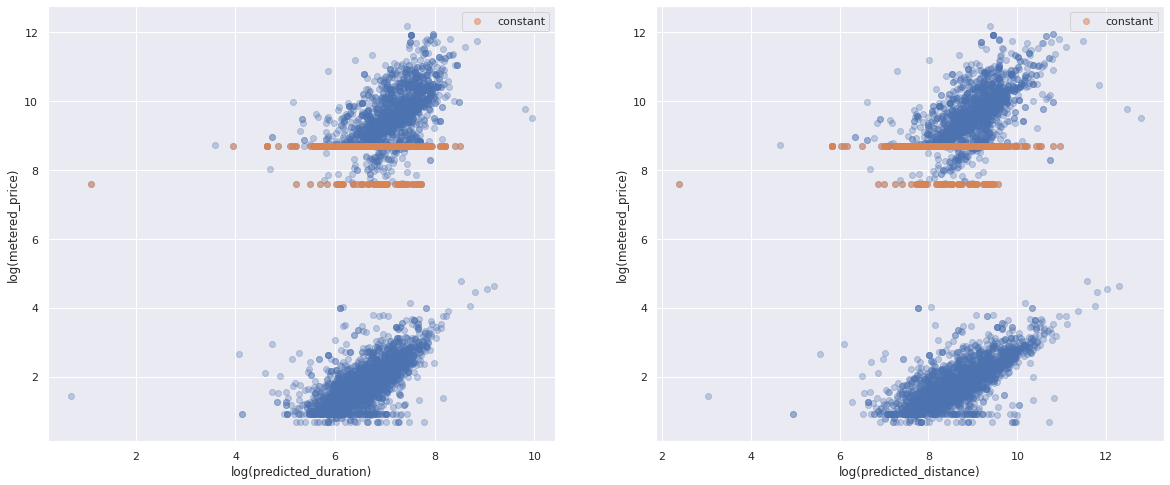

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['predicted_duration'], trips['metered_price'], alpha=0.3)
ax[0].scatter(trips.loc[mask, 'predicted_duration'], 
              trips.loc[mask, 'metered_price'],
              label='constant', alpha=0.5)
ax[0].set_xlabel('log(predicted_duration)')
ax[0].set_ylabel('log(metered_price)')
ax[0].legend()
ax[1].scatter(trips['predicted_distance'], trips['metered_price'], alpha=0.3)
ax[1].scatter(trips.loc[mask, 'predicted_distance'], 
              trips.loc[mask, 'metered_price'],
              label='constant', alpha=0.5)
ax[1].set_xlabel('log(predicted_distance)')
ax[1].set_ylabel('log(metered_price)')
ax[1].legend()

As you can see above there are some price constants that don't change:
* log(2000) - some kind of airport
* log(6000) - some kind of airport

__Note. There is no any data leakage. All these constants can be derived from GPS coordinates.__

If I knew pickup and dropoff coordinates I would also add:
* weather conditions, 
* airport stations,
* good/bad neighbourhoods.

Text(0, 0.5, 'log(metered_price)')

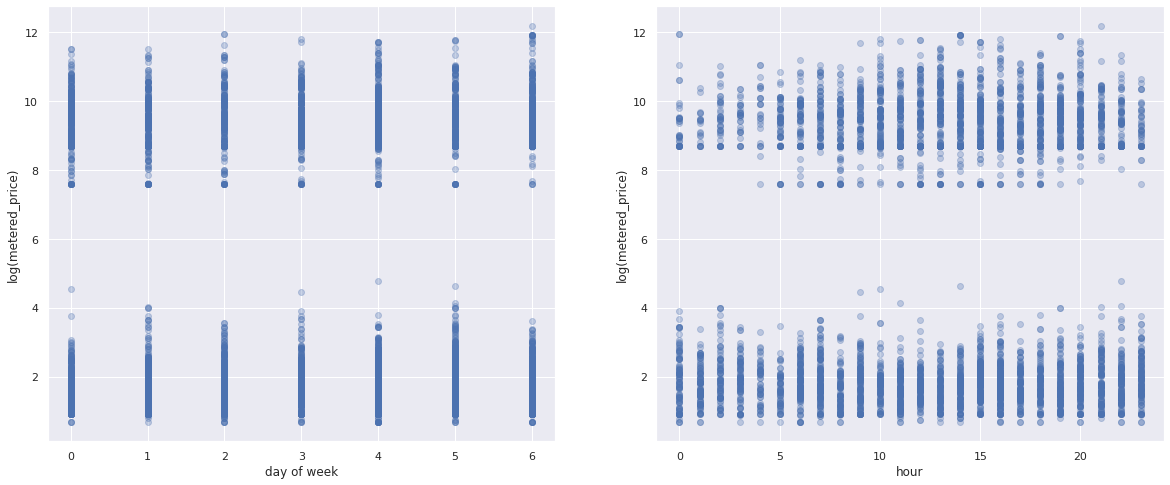

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['calc_created'].dt.dayofweek, trips['metered_price'], alpha=0.3)
ax[0].set_xlabel('day of week')
ax[0].set_ylabel('log(metered_price)')
ax[1].scatter(trips['calc_created'].dt.hour, trips['metered_price'], alpha=0.3)
ax[1].set_xlabel('hour')
ax[1].set_ylabel('log(metered_price)')

In [19]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    @staticmethod
    def get_part_day(x):
        if (x > 4) and (x <= 8):
            return 'Early Morning'
        elif (x > 8) and (x <= 12 ):
            return 'Morning'
        elif (x > 12) and (x <= 16):
            return'Noon'
        elif (x > 16) and (x <= 20) :
            return 'Eve'
        elif (x > 20) and (x <= 24):
            return'Night'
        elif (x <= 4):
            return'Late Night'
    
    def transform(self, X, y=None):
        # time & date features
        X.loc[:, 'day_of_week'] = X['calc_created'].dt.dayofweek
        X.loc[:, 'is_weekend'] = X['day_of_week'] > 4
#         X.loc[:, 'month'] = X['calc_created'].dt.month
        X.loc[:, 'hour_of_day'] = X['calc_created'].dt.hour
        X.loc[:, 'part_of_day'] = X['hour_of_day'].apply(self.get_part_day)
        
        # speed feature
        X.loc[:, 'speed'] = X['predicted_distance'] / X['predicted_duration']
#         grouped = ['order_id_new', 'calc_created']
#         cnt_ticket_id_new = X.groupby(grouped)['ticket_id_new'].count().reset_index()
#         cnt_ticket_id_new = cnt_ticket_id_new.rename(columns={'ticket_id_new': 'cnt_ticket_id_new'})
#         X = pd.merge(X, cnt_ticket_id_new, how='left', on=grouped)
        
        # airport features
        X.loc[:, 'isairport_2000'] = X['metered_price'] == np.log(2000)
        X.loc[:, 'isairport_6000'] = X['metered_price'] == np.log(6000)
        
        return X

In [20]:
trips = FeatureTransformer().transform(trips)

We are going to use 'upfront_price' column to calculate our baseline.

In [21]:
UPFRONT_PRICE = trips.loc[:, 'upfront_price']

## One-hot-encoding of categorical features

In [22]:
CATEGORICAL_COLS = [
    'day_of_week', 'part_of_day',
    'dest_change_number', 'prediction_price_type', 
    'change_reason_pricing', 'entered_by',
]
        
DROP_COLS = [
    'order_id_new', 'calc_created', 'upfront_price', 
    'order_try_id_new', 'distance', 'duration', 'ticket_id_new',
    'b_state', 'device_token', 'rider_app_version', 'order_state',
    'order_try_state', 'driver_app_version', 'driver_device_uid_new',
    'device_name', 'fraud_score'
]

In [23]:
class ColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols, categorical_cols):
        self.categorical_cols = categorical_cols
        self.drop_cols = drop_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.get_dummies(X, columns=self.categorical_cols)
        X.drop(columns=self.drop_cols, inplace=True)
        
        return X

In [24]:
trips = ColumnTransformer(DROP_COLS, CATEGORICAL_COLS).transform(trips)

In [25]:
steps = [
    ('log_transformer', LogTransformer(LOGCOLS)),
    ('clean_transformer', CleanTransformer()),
    ('feature_transformer', FeatureTransformer()),
    ('column_transformer', ColumnTransformer(DROP_COLS, CATEGORICAL_COLS))
]

preprocessing = Pipeline(steps)

# Support functions

To compare quality of our models we are going to use RMSE metric.

In [26]:
def rmse_decorator(func):
    @functools.wraps(func)
    def wrapper_rmse(*args, **kwargs):
        if len(args) == 3:
            return make_scorer(func)(*args, **kwargs) 
        else:
            return func(*args, **kwargs)
    
    return wrapper_rmse


@rmse_decorator
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [27]:
def print_results(estimator, X_test, y_test):
    print('R^2 = {:.5f}'.format(estimator.score(X_test, y_test)))
    print('RMSE = {:.5f}'.format(rmse(estimator, X_test, y_test)))
    mask = UPFRONT_PRICE[y_test.index].notna()
    baseline = rmse(y_test.loc[mask], UPFRONT_PRICE[y_test.index].loc[mask])
    print('Baseline RMSE = {:.5f}'.format(baseline))

In [28]:
def plot_results(X, y, y_pred):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].scatter(X['test']['predicted_duration'], y['test'], label='test')
    ax[0].scatter(X['test']['predicted_duration'], y_pred, label='pred')
    ax[0].set_xlabel('log(predicted_duration)')
    ax[0].set_ylabel('log(metered_price)')
    ax[0].legend()
    ax[1].scatter(X['test']['predicted_distance'], y['test'], label='test')
    ax[1].scatter(X['test']['predicted_distance'], y_pred, label='pred')
    ax[1].set_xlabel('log(predicted_distance)')
    ax[1].set_ylabel('log(metered_price)')
    ax[1].legend()

In [29]:
class TrainTestSplitTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=None):
        self.random_state = random_state
    
    @staticmethod
    def train_test_split(features, labels, train_size=.8, test_size=.2, **params):
        X, y = {}, {}

        X['train'], X['test'], y['train'], y['test'] = _train_test_split(
            features, 
            labels, 
            test_size=test_size, 
            train_size=train_size, 
            **params
        )

        return X, y
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        labels = X.loc[:, 'metered_price']
        features = X.drop(columns=['metered_price'])

        return self.train_test_split(features, labels, random_state=self.random_state)

In [30]:
class TrainValidTestSplitTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=None):
        self.random_state = random_state
    
    @staticmethod
    def train_valid_test_split(features, labels, train_size=.6, test_size=.2, valid_size=.2, **params):
        X, y = {}, {}

        X_train_valid, X['test'], y_train_valid, y['test'] = _train_test_split(
            features, 
            labels, 
            test_size=test_size, 
            train_size=train_size + valid_size,
            **params
        )
        X['train'], X['valid'], y['train'], y['valid'] = _train_test_split(
            X_train_valid, 
            y_train_valid, 
            test_size=valid_size, 
            train_size=train_size + test_size, 
            **params
        )

        return X, y
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        labels = X.loc[:, 'metered_price']
        features = X.drop(columns=['metered_price'])

        return self.train_valid_test_split(features, labels, random_state=self.random_state)

In [31]:
steps = [
    ('preprocessing', preprocessing),
    ('splitting', TrainTestSplitTransformer(random_state=42)),
]

train_test_splitting = Pipeline(steps)

steps = [
    ('preprocessing', preprocessing),
    ('splitting', TrainValidTestSplitTransformer(random_state=42)),
]

train_valid_test_splitting = Pipeline(steps)

# Linear model

In [32]:
trips = download_dataset(DOWNLOAD_URL)
X, y = train_test_splitting.transform(trips)

In [33]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=[7, 10, 11, 15, 18, 20]))
]
linear_pipe = Pipeline(steps)
linear_pipe.fit(X['train'], y['train'])
print('best_alpha = {}'.format(linear_pipe['ridge'].alpha_))
y_pred = linear_pipe.predict(X['test'])
print_results(linear_pipe, X['test'], y['test'])

best_alpha = 20
R^2 = 0.98734
RMSE = 0.43178
Baseline RMSE = 0.41872


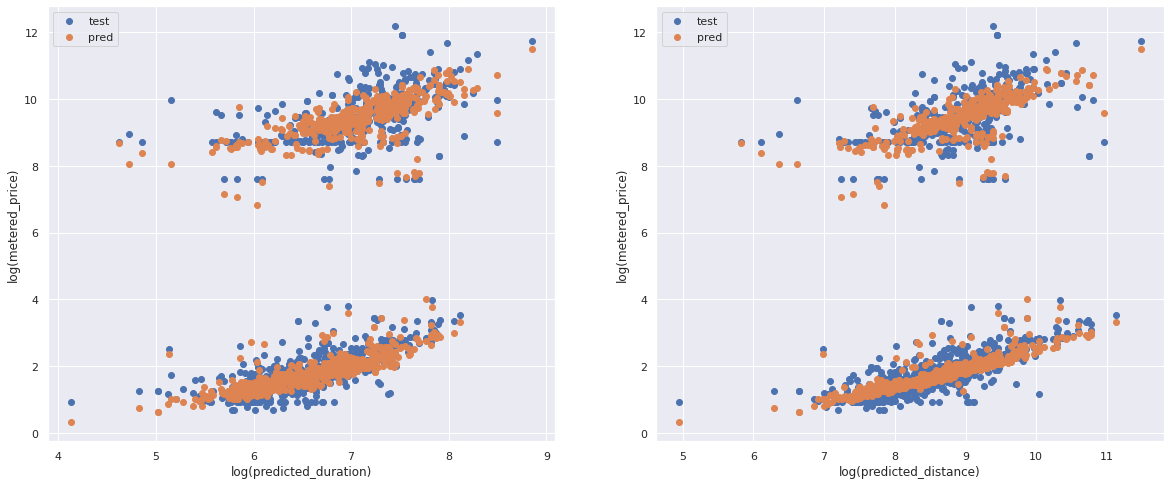

In [34]:
plot_results(X, y, y_pred)

# LGBM

In [35]:
trips = download_dataset(DOWNLOAD_URL)
X, y = train_valid_test_splitting.transform(trips)

In [36]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
#     ('lgb', lgb.LGBMRegressor(random_state=42))
]
lgb_pipe = Pipeline(steps)

param_grid = {
    'max_depth': [5, 10, 20, 30],
    'n_estimators': [50, 70, 80, 100],
    'early_stopping_rounds': [10]
}


grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)
grid_search.fit(lgb_pipe.fit_transform(X['train']), y['train'], 
                eval_set=[(lgb_pipe.transform(X['valid']), y['valid'])], 
                eval_metric='rmse')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49369	valid_0's l2: 12.2059
[2]	valid_0's rmse: 3.15314	valid_0's l2: 9.94232
[3]	valid_0's rmse: 2.84705	valid_0's l2: 8.10567
[4]	valid_0's rmse: 2.5733	valid_0's l2: 6.62187
[5]	valid_0's rmse: 2.3274	valid_0's l2: 5.41678
[6]	valid_0's rmse: 2.10631	valid_0's l2: 4.43655
[7]	valid_0's rmse: 1.90916	valid_0's l2: 3.64488
[8]	valid_0's rmse: 1.73235	valid_0's l2: 3.00103
[9]	valid_0's rmse: 1.5732	valid_0's l2: 2.47496
[10]	valid_0's rmse: 1.43143	valid_0's l2: 2.04901
[11]	valid_0's rmse: 1.30531	valid_0's l2: 1.70382
[12]	valid_0's rmse: 1.19311	valid_0's l2: 1.4235
[13]	valid_0's rmse: 1.09333	valid_0's l2: 1.19536
[14]	valid_0's rmse: 1.00577	valid_0's l2: 1.01157
[15]	valid_0's rmse: 0.928008	valid_0's l2: 0.861198
[16]	valid_0's rmse: 0.859566	valid_0's l2: 0.73885

[CV] END early_stopping_rounds=10, max_depth=5, n_estimators=50; total time=   0.7s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49309	valid_0's l2: 12.2017
[2]	valid_0's rmse: 3.15188	valid_0's l2: 9.93433
[3]	valid_0's rmse: 2.84584	valid_0's l2: 8.09879
[4]	valid_0's rmse: 2.57076	valid_0's l2: 6.60879
[5]	valid_0's rmse: 2.32416	valid_0's l2: 5.4017
[6]	valid_0's rmse: 2.10294	valid_0's l2: 4.42234
[7]	valid_0's rmse: 1.90577	valid_0's l2: 3.63196
[8]	valid_0's rmse: 1.72938	valid_0's l2: 2.99075
[9]	valid_0's rmse: 1.57139	valid_0's l2: 2.46925
[10]	valid_0's rmse: 1.43059	valid_0's l2: 2.0466
[11]	valid_0's rmse: 1.30449	valid_0's l2: 1.7017
[12]	valid_0's rmse: 1.19194	valid_0's l2: 1.42072
[13]	valid_0's rmse: 1.09188	valid_0's l2: 1.19221
[14]	valid_0's rmse: 1.00368	valid_0's l2: 1.00737
[15]	valid_0's rmse: 0.926103	valid_0's l2: 0.857666
[16]	valid_0's rmse: 0.8575

[57]	valid_0's rmse: 0.441673	valid_0's l2: 0.195075
[58]	valid_0's rmse: 0.441736	valid_0's l2: 0.19513
[59]	valid_0's rmse: 0.441917	valid_0's l2: 0.19529
[60]	valid_0's rmse: 0.441778	valid_0's l2: 0.195167
[61]	valid_0's rmse: 0.441912	valid_0's l2: 0.195286
[62]	valid_0's rmse: 0.441303	valid_0's l2: 0.194748
[63]	valid_0's rmse: 0.441277	valid_0's l2: 0.194726
[64]	valid_0's rmse: 0.441334	valid_0's l2: 0.194776
[65]	valid_0's rmse: 0.441086	valid_0's l2: 0.194557
[66]	valid_0's rmse: 0.441184	valid_0's l2: 0.194643
[67]	valid_0's rmse: 0.440522	valid_0's l2: 0.194059
[68]	valid_0's rmse: 0.440539	valid_0's l2: 0.194074
[69]	valid_0's rmse: 0.440066	valid_0's l2: 0.193658
[70]	valid_0's rmse: 0.440124	valid_0's l2: 0.193709
[CV] END early_stopping_rounds=10, max_depth=5, n_estimators=70; total time=   0.5s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49062	valid_0's l2: 

[1]	valid_0's rmse: 3.49309	valid_0's l2: 12.2017
[2]	valid_0's rmse: 3.15188	valid_0's l2: 9.93433
[3]	valid_0's rmse: 2.84584	valid_0's l2: 8.09879
[4]	valid_0's rmse: 2.57076	valid_0's l2: 6.60879
[5]	valid_0's rmse: 2.32416	valid_0's l2: 5.4017
[6]	valid_0's rmse: 2.10294	valid_0's l2: 4.42234
[7]	valid_0's rmse: 1.90577	valid_0's l2: 3.63196
[8]	valid_0's rmse: 1.72938	valid_0's l2: 2.99075
[9]	valid_0's rmse: 1.57139	valid_0's l2: 2.46925
[10]	valid_0's rmse: 1.43059	valid_0's l2: 2.0466
[11]	valid_0's rmse: 1.30449	valid_0's l2: 1.7017
[12]	valid_0's rmse: 1.19194	valid_0's l2: 1.42072
[13]	valid_0's rmse: 1.09188	valid_0's l2: 1.19221
[14]	valid_0's rmse: 1.00368	valid_0's l2: 1.00737
[15]	valid_0's rmse: 0.926103	valid_0's l2: 0.857666
[16]	valid_0's rmse: 0.857529	valid_0's l2: 0.735356
[17]	valid_0's rmse: 0.798112	valid_0's l2: 0.636982
[18]	valid_0's rmse: 0.746272	valid_0's l2: 0.556921
[19]	valid_0's rmse: 0.701315	valid_0's l2: 0.491842
[20]	valid_0's rmse: 0.662439	val

[56]	valid_0's rmse: 0.441818	valid_0's l2: 0.195203
[57]	valid_0's rmse: 0.441673	valid_0's l2: 0.195075
[58]	valid_0's rmse: 0.441736	valid_0's l2: 0.19513
[59]	valid_0's rmse: 0.441917	valid_0's l2: 0.19529
[60]	valid_0's rmse: 0.441778	valid_0's l2: 0.195167
[61]	valid_0's rmse: 0.441912	valid_0's l2: 0.195286
[62]	valid_0's rmse: 0.441303	valid_0's l2: 0.194748
[63]	valid_0's rmse: 0.441277	valid_0's l2: 0.194726
[64]	valid_0's rmse: 0.441334	valid_0's l2: 0.194776
[65]	valid_0's rmse: 0.441086	valid_0's l2: 0.194557
[66]	valid_0's rmse: 0.441184	valid_0's l2: 0.194643
[67]	valid_0's rmse: 0.440522	valid_0's l2: 0.194059
[68]	valid_0's rmse: 0.440539	valid_0's l2: 0.194074
[69]	valid_0's rmse: 0.440066	valid_0's l2: 0.193658
[70]	valid_0's rmse: 0.440124	valid_0's l2: 0.193709
[71]	valid_0's rmse: 0.44037	valid_0's l2: 0.193926
[72]	valid_0's rmse: 0.440938	valid_0's l2: 0.194426
[73]	valid_0's rmse: 0.440843	valid_0's l2: 0.194342
[74]	valid_0's rmse: 0.440406	valid_0's l2: 0.193

[54]	valid_0's rmse: 0.448356	valid_0's l2: 0.201023
[55]	valid_0's rmse: 0.448725	valid_0's l2: 0.201354
[56]	valid_0's rmse: 0.448723	valid_0's l2: 0.201352
[57]	valid_0's rmse: 0.448718	valid_0's l2: 0.201348
[58]	valid_0's rmse: 0.448777	valid_0's l2: 0.2014
[59]	valid_0's rmse: 0.448954	valid_0's l2: 0.20156
[60]	valid_0's rmse: 0.448875	valid_0's l2: 0.201488
[61]	valid_0's rmse: 0.448837	valid_0's l2: 0.201454
[62]	valid_0's rmse: 0.448745	valid_0's l2: 0.201372
[63]	valid_0's rmse: 0.448839	valid_0's l2: 0.201457
[64]	valid_0's rmse: 0.448678	valid_0's l2: 0.201312
[CV] END early_stopping_rounds=10, max_depth=5, n_estimators=80; total time=   0.6s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49309	valid_0's l2: 12.2017
[2]	valid_0's rmse: 3.15188	valid_0's l2: 9.93433
[3]	valid_0's rmse: 2.84584	valid_0's l2: 8.09879
[4]	valid_0's rmse: 2.57076	valid_0's l2: 6.60879
[5

[1]	valid_0's rmse: 3.49369	valid_0's l2: 12.2059
[2]	valid_0's rmse: 3.15314	valid_0's l2: 9.94232
[3]	valid_0's rmse: 2.84705	valid_0's l2: 8.10567
[4]	valid_0's rmse: 2.5733	valid_0's l2: 6.62187
[5]	valid_0's rmse: 2.3274	valid_0's l2: 5.41678
[6]	valid_0's rmse: 2.10631	valid_0's l2: 4.43655
[7]	valid_0's rmse: 1.90916	valid_0's l2: 3.64488
[8]	valid_0's rmse: 1.73235	valid_0's l2: 3.00103
[9]	valid_0's rmse: 1.5732	valid_0's l2: 2.47496
[10]	valid_0's rmse: 1.43143	valid_0's l2: 2.04901
[11]	valid_0's rmse: 1.30531	valid_0's l2: 1.70382
[12]	valid_0's rmse: 1.19311	valid_0's l2: 1.4235
[13]	valid_0's rmse: 1.09333	valid_0's l2: 1.19536
[14]	valid_0's rmse: 1.00577	valid_0's l2: 1.01157
[15]	valid_0's rmse: 0.928008	valid_0's l2: 0.861198
[16]	valid_0's rmse: 0.859566	valid_0's l2: 0.738854
[17]	valid_0's rmse: 0.799994	valid_0's l2: 0.63999
[18]	valid_0's rmse: 0.747962	valid_0's l2: 0.559448
[19]	valid_0's rmse: 0.702607	valid_0's l2: 0.493656
[20]	valid_0's rmse: 0.66391	valid_

[1]	valid_0's rmse: 3.49299	valid_0's l2: 12.201
[2]	valid_0's rmse: 3.15146	valid_0's l2: 9.93168
[3]	valid_0's rmse: 2.84424	valid_0's l2: 8.08973
[4]	valid_0's rmse: 2.56901	valid_0's l2: 6.59983
[5]	valid_0's rmse: 2.32186	valid_0's l2: 5.39103
[6]	valid_0's rmse: 2.10036	valid_0's l2: 4.41151
[7]	valid_0's rmse: 1.90231	valid_0's l2: 3.61878
[8]	valid_0's rmse: 1.72599	valid_0's l2: 2.97905
[9]	valid_0's rmse: 1.56787	valid_0's l2: 2.45821
[10]	valid_0's rmse: 1.42639	valid_0's l2: 2.03458
[11]	valid_0's rmse: 1.29985	valid_0's l2: 1.68961
[12]	valid_0's rmse: 1.18745	valid_0's l2: 1.41003
[13]	valid_0's rmse: 1.08776	valid_0's l2: 1.18322
[14]	valid_0's rmse: 0.999331	valid_0's l2: 0.998663
[15]	valid_0's rmse: 0.922009	valid_0's l2: 0.8501
[16]	valid_0's rmse: 0.853993	valid_0's l2: 0.729304
[17]	valid_0's rmse: 0.795179	valid_0's l2: 0.632309
[18]	valid_0's rmse: 0.743294	valid_0's l2: 0.552486
[19]	valid_0's rmse: 0.698669	valid_0's l2: 0.488138
[20]	valid_0's rmse: 0.659684	v

[34]	valid_0's rmse: 0.466165	valid_0's l2: 0.21731
[35]	valid_0's rmse: 0.463158	valid_0's l2: 0.214515
[36]	valid_0's rmse: 0.461302	valid_0's l2: 0.2128
[37]	valid_0's rmse: 0.459617	valid_0's l2: 0.211247
[38]	valid_0's rmse: 0.4578	valid_0's l2: 0.20958
[39]	valid_0's rmse: 0.456689	valid_0's l2: 0.208565
[40]	valid_0's rmse: 0.45477	valid_0's l2: 0.206816
[41]	valid_0's rmse: 0.453355	valid_0's l2: 0.205531
[42]	valid_0's rmse: 0.452621	valid_0's l2: 0.204866
[43]	valid_0's rmse: 0.45221	valid_0's l2: 0.204494
[44]	valid_0's rmse: 0.451636	valid_0's l2: 0.203975
[45]	valid_0's rmse: 0.451063	valid_0's l2: 0.203458
[46]	valid_0's rmse: 0.450264	valid_0's l2: 0.202738
[47]	valid_0's rmse: 0.449422	valid_0's l2: 0.20198
[48]	valid_0's rmse: 0.44852	valid_0's l2: 0.20117
[49]	valid_0's rmse: 0.447973	valid_0's l2: 0.20068
[50]	valid_0's rmse: 0.447207	valid_0's l2: 0.199994
[51]	valid_0's rmse: 0.446705	valid_0's l2: 0.199545
[52]	valid_0's rmse: 0.446579	valid_0's l2: 0.199433
[53]	

[16]	valid_0's rmse: 0.845667	valid_0's l2: 0.715152
[17]	valid_0's rmse: 0.785173	valid_0's l2: 0.616497
[18]	valid_0's rmse: 0.732534	valid_0's l2: 0.536606
[19]	valid_0's rmse: 0.687272	valid_0's l2: 0.472343
[20]	valid_0's rmse: 0.648596	valid_0's l2: 0.420677
[21]	valid_0's rmse: 0.615185	valid_0's l2: 0.378453
[22]	valid_0's rmse: 0.586442	valid_0's l2: 0.343915
[23]	valid_0's rmse: 0.562195	valid_0's l2: 0.316064
[24]	valid_0's rmse: 0.541454	valid_0's l2: 0.293172
[25]	valid_0's rmse: 0.523483	valid_0's l2: 0.274035
[26]	valid_0's rmse: 0.508982	valid_0's l2: 0.259063
[27]	valid_0's rmse: 0.496654	valid_0's l2: 0.246666
[28]	valid_0's rmse: 0.486579	valid_0's l2: 0.236759
[29]	valid_0's rmse: 0.478599	valid_0's l2: 0.229057
[30]	valid_0's rmse: 0.471525	valid_0's l2: 0.222335
[31]	valid_0's rmse: 0.465727	valid_0's l2: 0.216901
[32]	valid_0's rmse: 0.461002	valid_0's l2: 0.212523
[33]	valid_0's rmse: 0.456357	valid_0's l2: 0.208262
[34]	valid_0's rmse: 0.453608	valid_0's l2: 0.

[24]	valid_0's rmse: 0.543872	valid_0's l2: 0.295797
[25]	valid_0's rmse: 0.525895	valid_0's l2: 0.276566
[26]	valid_0's rmse: 0.509984	valid_0's l2: 0.260084
[27]	valid_0's rmse: 0.496828	valid_0's l2: 0.246838
[28]	valid_0's rmse: 0.486123	valid_0's l2: 0.236315
[29]	valid_0's rmse: 0.477104	valid_0's l2: 0.227628
[30]	valid_0's rmse: 0.468589	valid_0's l2: 0.219576
[31]	valid_0's rmse: 0.461886	valid_0's l2: 0.213339
[32]	valid_0's rmse: 0.456439	valid_0's l2: 0.208336
[33]	valid_0's rmse: 0.452375	valid_0's l2: 0.204644
[34]	valid_0's rmse: 0.448707	valid_0's l2: 0.201338
[35]	valid_0's rmse: 0.445879	valid_0's l2: 0.198808
[36]	valid_0's rmse: 0.443511	valid_0's l2: 0.196702
[37]	valid_0's rmse: 0.441785	valid_0's l2: 0.195174
[38]	valid_0's rmse: 0.440255	valid_0's l2: 0.193824
[39]	valid_0's rmse: 0.439198	valid_0's l2: 0.192895
[40]	valid_0's rmse: 0.438474	valid_0's l2: 0.192259
[41]	valid_0's rmse: 0.437405	valid_0's l2: 0.191323
[42]	valid_0's rmse: 0.436571	valid_0's l2: 0.

[51]	valid_0's rmse: 0.440469	valid_0's l2: 0.194013
[52]	valid_0's rmse: 0.440813	valid_0's l2: 0.194316
[53]	valid_0's rmse: 0.440865	valid_0's l2: 0.194362
[54]	valid_0's rmse: 0.440596	valid_0's l2: 0.194125
[55]	valid_0's rmse: 0.440609	valid_0's l2: 0.194136
[56]	valid_0's rmse: 0.440665	valid_0's l2: 0.194186
[57]	valid_0's rmse: 0.44123	valid_0's l2: 0.194684
[58]	valid_0's rmse: 0.44123	valid_0's l2: 0.194684
[59]	valid_0's rmse: 0.441504	valid_0's l2: 0.194925
[60]	valid_0's rmse: 0.441665	valid_0's l2: 0.195068
[61]	valid_0's rmse: 0.442126	valid_0's l2: 0.195475
[CV] END early_stopping_rounds=10, max_depth=10, n_estimators=70; total time=   1.3s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49264	valid_0's l2: 12.1986
[2]	valid_0's rmse: 3.15129	valid_0's l2: 9.93062
[3]	valid_0's rmse: 2.84443	valid_0's l2: 8.09078
[4]	valid_0's rmse: 2.56872	valid_0's l2: 6.5983
[

[1]	valid_0's rmse: 3.49254	valid_0's l2: 12.1979
[2]	valid_0's rmse: 3.15101	valid_0's l2: 9.92885
[3]	valid_0's rmse: 2.84442	valid_0's l2: 8.09072
[4]	valid_0's rmse: 2.57029	valid_0's l2: 6.60638
[5]	valid_0's rmse: 2.32482	valid_0's l2: 5.40477
[6]	valid_0's rmse: 2.10353	valid_0's l2: 4.42483
[7]	valid_0's rmse: 1.90503	valid_0's l2: 3.62916
[8]	valid_0's rmse: 1.72662	valid_0's l2: 2.98123
[9]	valid_0's rmse: 1.56736	valid_0's l2: 2.45662
[10]	valid_0's rmse: 1.42576	valid_0's l2: 2.03279
[11]	valid_0's rmse: 1.30002	valid_0's l2: 1.69004
[12]	valid_0's rmse: 1.18813	valid_0's l2: 1.41165
[13]	valid_0's rmse: 1.08858	valid_0's l2: 1.185
[14]	valid_0's rmse: 1.00004	valid_0's l2: 1.00007
[15]	valid_0's rmse: 0.922511	valid_0's l2: 0.851026
[16]	valid_0's rmse: 0.853704	valid_0's l2: 0.728811
[17]	valid_0's rmse: 0.792584	valid_0's l2: 0.628189
[18]	valid_0's rmse: 0.739728	valid_0's l2: 0.547197
[19]	valid_0's rmse: 0.693743	valid_0's l2: 0.481279
[20]	valid_0's rmse: 0.653268	va

[CV] END early_stopping_rounds=10, max_depth=10, n_estimators=80; total time=   1.3s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49227	valid_0's l2: 12.1959
[2]	valid_0's rmse: 3.15089	valid_0's l2: 9.92809
[3]	valid_0's rmse: 2.84334	valid_0's l2: 8.08458
[4]	valid_0's rmse: 2.56831	valid_0's l2: 6.59619
[5]	valid_0's rmse: 2.321	valid_0's l2: 5.38704
[6]	valid_0's rmse: 2.0985	valid_0's l2: 4.40372
[7]	valid_0's rmse: 1.89947	valid_0's l2: 3.60798
[8]	valid_0's rmse: 1.72189	valid_0's l2: 2.96492
[9]	valid_0's rmse: 1.56313	valid_0's l2: 2.44337
[10]	valid_0's rmse: 1.42004	valid_0's l2: 2.01651
[11]	valid_0's rmse: 1.29348	valid_0's l2: 1.67309
[12]	valid_0's rmse: 1.18063	valid_0's l2: 1.39389
[13]	valid_0's rmse: 1.08045	valid_0's l2: 1.16738
[14]	valid_0's rmse: 0.991714	valid_0's l2: 0.983497
[15]	valid_0's rmse: 0.913824	valid_0's l2: 0.835075
[16]	valid_0's rmse: 0.8

[23]	valid_0's rmse: 0.566508	valid_0's l2: 0.320931
[24]	valid_0's rmse: 0.545262	valid_0's l2: 0.297311
[25]	valid_0's rmse: 0.528009	valid_0's l2: 0.278793
[26]	valid_0's rmse: 0.513219	valid_0's l2: 0.263393
[27]	valid_0's rmse: 0.501074	valid_0's l2: 0.251075
[28]	valid_0's rmse: 0.490662	valid_0's l2: 0.240749
[29]	valid_0's rmse: 0.482443	valid_0's l2: 0.232751
[30]	valid_0's rmse: 0.475009	valid_0's l2: 0.225633
[31]	valid_0's rmse: 0.468952	valid_0's l2: 0.219916
[32]	valid_0's rmse: 0.463652	valid_0's l2: 0.214973
[33]	valid_0's rmse: 0.459827	valid_0's l2: 0.211441
[34]	valid_0's rmse: 0.455466	valid_0's l2: 0.20745
[35]	valid_0's rmse: 0.452401	valid_0's l2: 0.204666
[36]	valid_0's rmse: 0.450123	valid_0's l2: 0.20261
[37]	valid_0's rmse: 0.448073	valid_0's l2: 0.20077
[38]	valid_0's rmse: 0.447073	valid_0's l2: 0.199874
[39]	valid_0's rmse: 0.445689	valid_0's l2: 0.198638
[40]	valid_0's rmse: 0.444509	valid_0's l2: 0.197588
[41]	valid_0's rmse: 0.44392	valid_0's l2: 0.1970

[21]	valid_0's rmse: 0.616627	valid_0's l2: 0.380229
[22]	valid_0's rmse: 0.588007	valid_0's l2: 0.345753
[23]	valid_0's rmse: 0.563591	valid_0's l2: 0.317634
[24]	valid_0's rmse: 0.543323	valid_0's l2: 0.295199
[25]	valid_0's rmse: 0.525727	valid_0's l2: 0.276389
[26]	valid_0's rmse: 0.511709	valid_0's l2: 0.261846
[27]	valid_0's rmse: 0.499124	valid_0's l2: 0.249125
[28]	valid_0's rmse: 0.488567	valid_0's l2: 0.238698
[29]	valid_0's rmse: 0.480424	valid_0's l2: 0.230807
[30]	valid_0's rmse: 0.473715	valid_0's l2: 0.224406
[31]	valid_0's rmse: 0.468109	valid_0's l2: 0.219126
[32]	valid_0's rmse: 0.463224	valid_0's l2: 0.214576
[33]	valid_0's rmse: 0.45887	valid_0's l2: 0.210562
[34]	valid_0's rmse: 0.455523	valid_0's l2: 0.207501
[35]	valid_0's rmse: 0.45269	valid_0's l2: 0.204928
[36]	valid_0's rmse: 0.450307	valid_0's l2: 0.202776
[37]	valid_0's rmse: 0.44877	valid_0's l2: 0.201394
[38]	valid_0's rmse: 0.44763	valid_0's l2: 0.200373
[39]	valid_0's rmse: 0.446119	valid_0's l2: 0.1990

[29]	valid_0's rmse: 0.478384	valid_0's l2: 0.228851
[30]	valid_0's rmse: 0.471706	valid_0's l2: 0.222507
[31]	valid_0's rmse: 0.466205	valid_0's l2: 0.217347
[32]	valid_0's rmse: 0.461349	valid_0's l2: 0.212842
[33]	valid_0's rmse: 0.457773	valid_0's l2: 0.209556
[34]	valid_0's rmse: 0.454719	valid_0's l2: 0.206769
[35]	valid_0's rmse: 0.452458	valid_0's l2: 0.204719
[36]	valid_0's rmse: 0.449917	valid_0's l2: 0.202425
[37]	valid_0's rmse: 0.448429	valid_0's l2: 0.201088
[38]	valid_0's rmse: 0.446696	valid_0's l2: 0.199537
[39]	valid_0's rmse: 0.445646	valid_0's l2: 0.198601
[40]	valid_0's rmse: 0.444369	valid_0's l2: 0.197464
[41]	valid_0's rmse: 0.443627	valid_0's l2: 0.196805
[42]	valid_0's rmse: 0.443153	valid_0's l2: 0.196385
[43]	valid_0's rmse: 0.442313	valid_0's l2: 0.19564
[44]	valid_0's rmse: 0.440993	valid_0's l2: 0.194475
[45]	valid_0's rmse: 0.440624	valid_0's l2: 0.194149
[46]	valid_0's rmse: 0.440375	valid_0's l2: 0.19393
[47]	valid_0's rmse: 0.439987	valid_0's l2: 0.19

[19]	valid_0's rmse: 0.69369	valid_0's l2: 0.481206
[20]	valid_0's rmse: 0.65314	valid_0's l2: 0.426592
[21]	valid_0's rmse: 0.619307	valid_0's l2: 0.383542
[22]	valid_0's rmse: 0.590713	valid_0's l2: 0.348942
[23]	valid_0's rmse: 0.565071	valid_0's l2: 0.319305
[24]	valid_0's rmse: 0.543573	valid_0's l2: 0.295471
[25]	valid_0's rmse: 0.525312	valid_0's l2: 0.275952
[26]	valid_0's rmse: 0.510225	valid_0's l2: 0.260329
[27]	valid_0's rmse: 0.497571	valid_0's l2: 0.247577
[28]	valid_0's rmse: 0.486953	valid_0's l2: 0.237123
[29]	valid_0's rmse: 0.477834	valid_0's l2: 0.228325
[30]	valid_0's rmse: 0.470616	valid_0's l2: 0.221479
[31]	valid_0's rmse: 0.464029	valid_0's l2: 0.215323
[32]	valid_0's rmse: 0.459449	valid_0's l2: 0.211094
[33]	valid_0's rmse: 0.454623	valid_0's l2: 0.206682
[34]	valid_0's rmse: 0.450802	valid_0's l2: 0.203222
[35]	valid_0's rmse: 0.447717	valid_0's l2: 0.200451
[36]	valid_0's rmse: 0.446214	valid_0's l2: 0.199107
[37]	valid_0's rmse: 0.443407	valid_0's l2: 0.19

[16]	valid_0's rmse: 0.848663	valid_0's l2: 0.720228
[17]	valid_0's rmse: 0.787617	valid_0's l2: 0.62034
[18]	valid_0's rmse: 0.735078	valid_0's l2: 0.54034
[19]	valid_0's rmse: 0.68913	valid_0's l2: 0.4749
[20]	valid_0's rmse: 0.648799	valid_0's l2: 0.42094
[21]	valid_0's rmse: 0.615418	valid_0's l2: 0.378739
[22]	valid_0's rmse: 0.586043	valid_0's l2: 0.343446
[23]	valid_0's rmse: 0.561048	valid_0's l2: 0.314775
[24]	valid_0's rmse: 0.53996	valid_0's l2: 0.291556
[25]	valid_0's rmse: 0.522576	valid_0's l2: 0.273086
[26]	valid_0's rmse: 0.507885	valid_0's l2: 0.257947
[27]	valid_0's rmse: 0.49513	valid_0's l2: 0.245154
[28]	valid_0's rmse: 0.484832	valid_0's l2: 0.235062
[29]	valid_0's rmse: 0.476697	valid_0's l2: 0.22724
[30]	valid_0's rmse: 0.470576	valid_0's l2: 0.221441
[31]	valid_0's rmse: 0.464511	valid_0's l2: 0.215771
[32]	valid_0's rmse: 0.460074	valid_0's l2: 0.211668
[33]	valid_0's rmse: 0.456317	valid_0's l2: 0.208225
[34]	valid_0's rmse: 0.452464	valid_0's l2: 0.204723
[3

[1]	valid_0's rmse: 3.48994	valid_0's l2: 12.1797
[2]	valid_0's rmse: 3.14891	valid_0's l2: 9.91561
[3]	valid_0's rmse: 2.8418	valid_0's l2: 8.07584
[4]	valid_0's rmse: 2.56644	valid_0's l2: 6.58661
[5]	valid_0's rmse: 2.31931	valid_0's l2: 5.37918
[6]	valid_0's rmse: 2.09837	valid_0's l2: 4.40317
[7]	valid_0's rmse: 1.9	valid_0's l2: 3.60999
[8]	valid_0's rmse: 1.7222	valid_0's l2: 2.96597
[9]	valid_0's rmse: 1.56292	valid_0's l2: 2.44271
[10]	valid_0's rmse: 1.42124	valid_0's l2: 2.01991
[11]	valid_0's rmse: 1.2947	valid_0's l2: 1.67626
[12]	valid_0's rmse: 1.18174	valid_0's l2: 1.39651
[13]	valid_0's rmse: 1.08139	valid_0's l2: 1.1694
[14]	valid_0's rmse: 0.992921	valid_0's l2: 0.985893
[15]	valid_0's rmse: 0.914892	valid_0's l2: 0.837027
[16]	valid_0's rmse: 0.846567	valid_0's l2: 0.716676
[17]	valid_0's rmse: 0.786521	valid_0's l2: 0.618615
[18]	valid_0's rmse: 0.733602	valid_0's l2: 0.538173
[19]	valid_0's rmse: 0.687596	valid_0's l2: 0.472789
[20]	valid_0's rmse: 0.64897	valid_0

[26]	valid_0's rmse: 0.507885	valid_0's l2: 0.257947
[27]	valid_0's rmse: 0.49513	valid_0's l2: 0.245154
[28]	valid_0's rmse: 0.484832	valid_0's l2: 0.235062
[29]	valid_0's rmse: 0.476697	valid_0's l2: 0.22724
[30]	valid_0's rmse: 0.470576	valid_0's l2: 0.221441
[31]	valid_0's rmse: 0.464511	valid_0's l2: 0.215771
[32]	valid_0's rmse: 0.460074	valid_0's l2: 0.211668
[33]	valid_0's rmse: 0.456317	valid_0's l2: 0.208225
[34]	valid_0's rmse: 0.452464	valid_0's l2: 0.204723
[35]	valid_0's rmse: 0.450267	valid_0's l2: 0.20274
[36]	valid_0's rmse: 0.447785	valid_0's l2: 0.200511
[37]	valid_0's rmse: 0.446087	valid_0's l2: 0.198994
[38]	valid_0's rmse: 0.445002	valid_0's l2: 0.198027
[39]	valid_0's rmse: 0.443991	valid_0's l2: 0.197128
[40]	valid_0's rmse: 0.443033	valid_0's l2: 0.196278
[41]	valid_0's rmse: 0.442303	valid_0's l2: 0.195632
[42]	valid_0's rmse: 0.441706	valid_0's l2: 0.195104
[43]	valid_0's rmse: 0.441149	valid_0's l2: 0.194613
[44]	valid_0's rmse: 0.440356	valid_0's l2: 0.193

[56]	valid_0's rmse: 0.430981	valid_0's l2: 0.185745
[57]	valid_0's rmse: 0.431201	valid_0's l2: 0.185934
[58]	valid_0's rmse: 0.430584	valid_0's l2: 0.185403
[59]	valid_0's rmse: 0.430186	valid_0's l2: 0.18506
[60]	valid_0's rmse: 0.429965	valid_0's l2: 0.18487
[61]	valid_0's rmse: 0.430327	valid_0's l2: 0.185182
[62]	valid_0's rmse: 0.430666	valid_0's l2: 0.185473
[63]	valid_0's rmse: 0.430442	valid_0's l2: 0.18528
[64]	valid_0's rmse: 0.430579	valid_0's l2: 0.185398
[65]	valid_0's rmse: 0.430581	valid_0's l2: 0.1854
[66]	valid_0's rmse: 0.430994	valid_0's l2: 0.185756
[67]	valid_0's rmse: 0.431255	valid_0's l2: 0.185981
[68]	valid_0's rmse: 0.430784	valid_0's l2: 0.185575
[69]	valid_0's rmse: 0.430389	valid_0's l2: 0.185235
[70]	valid_0's rmse: 0.430252	valid_0's l2: 0.185116
[CV] END early_stopping_rounds=10, max_depth=20, n_estimators=80; total time=   0.8s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_

[1]	valid_0's rmse: 3.49264	valid_0's l2: 12.1986
[2]	valid_0's rmse: 3.15129	valid_0's l2: 9.93062
[3]	valid_0's rmse: 2.84443	valid_0's l2: 8.09078
[4]	valid_0's rmse: 2.56872	valid_0's l2: 6.5983
[5]	valid_0's rmse: 2.32263	valid_0's l2: 5.3946
[6]	valid_0's rmse: 2.1018	valid_0's l2: 4.41758
[7]	valid_0's rmse: 1.90392	valid_0's l2: 3.62491
[8]	valid_0's rmse: 1.72593	valid_0's l2: 2.97884
[9]	valid_0's rmse: 1.56673	valid_0's l2: 2.45464
[10]	valid_0's rmse: 1.42494	valid_0's l2: 2.03047
[11]	valid_0's rmse: 1.29889	valid_0's l2: 1.68712
[12]	valid_0's rmse: 1.18538	valid_0's l2: 1.40512
[13]	valid_0's rmse: 1.08486	valid_0's l2: 1.17692
[14]	valid_0's rmse: 0.995471	valid_0's l2: 0.990962
[15]	valid_0's rmse: 0.917588	valid_0's l2: 0.841967
[16]	valid_0's rmse: 0.848663	valid_0's l2: 0.720228
[17]	valid_0's rmse: 0.787617	valid_0's l2: 0.62034
[18]	valid_0's rmse: 0.735078	valid_0's l2: 0.54034
[19]	valid_0's rmse: 0.68913	valid_0's l2: 0.4749
[20]	valid_0's rmse: 0.648799	valid_

[16]	valid_0's rmse: 0.853257	valid_0's l2: 0.728048
[17]	valid_0's rmse: 0.792316	valid_0's l2: 0.627765
[18]	valid_0's rmse: 0.739467	valid_0's l2: 0.546812
[19]	valid_0's rmse: 0.69369	valid_0's l2: 0.481206
[20]	valid_0's rmse: 0.65314	valid_0's l2: 0.426592
[21]	valid_0's rmse: 0.619307	valid_0's l2: 0.383542
[22]	valid_0's rmse: 0.590713	valid_0's l2: 0.348942
[23]	valid_0's rmse: 0.565071	valid_0's l2: 0.319305
[24]	valid_0's rmse: 0.543573	valid_0's l2: 0.295471
[25]	valid_0's rmse: 0.525312	valid_0's l2: 0.275952
[26]	valid_0's rmse: 0.510225	valid_0's l2: 0.260329
[27]	valid_0's rmse: 0.497571	valid_0's l2: 0.247577
[28]	valid_0's rmse: 0.486953	valid_0's l2: 0.237123
[29]	valid_0's rmse: 0.477834	valid_0's l2: 0.228325
[30]	valid_0's rmse: 0.470616	valid_0's l2: 0.221479
[31]	valid_0's rmse: 0.464029	valid_0's l2: 0.215323
[32]	valid_0's rmse: 0.459449	valid_0's l2: 0.211094
[33]	valid_0's rmse: 0.454623	valid_0's l2: 0.206682
[34]	valid_0's rmse: 0.450802	valid_0's l2: 0.20

[26]	valid_0's rmse: 0.507777	valid_0's l2: 0.257837
[27]	valid_0's rmse: 0.494688	valid_0's l2: 0.244717
[28]	valid_0's rmse: 0.484592	valid_0's l2: 0.234829
[29]	valid_0's rmse: 0.476543	valid_0's l2: 0.227094
[30]	valid_0's rmse: 0.469561	valid_0's l2: 0.220487
[31]	valid_0's rmse: 0.46382	valid_0's l2: 0.215129
[32]	valid_0's rmse: 0.459459	valid_0's l2: 0.211102
[33]	valid_0's rmse: 0.455687	valid_0's l2: 0.207651
[34]	valid_0's rmse: 0.452555	valid_0's l2: 0.204806
[35]	valid_0's rmse: 0.449491	valid_0's l2: 0.202042
[36]	valid_0's rmse: 0.447203	valid_0's l2: 0.19999
[37]	valid_0's rmse: 0.445154	valid_0's l2: 0.198163
[38]	valid_0's rmse: 0.443365	valid_0's l2: 0.196573
[39]	valid_0's rmse: 0.441756	valid_0's l2: 0.195149
[40]	valid_0's rmse: 0.440495	valid_0's l2: 0.194036
[41]	valid_0's rmse: 0.439495	valid_0's l2: 0.193155
[42]	valid_0's rmse: 0.438949	valid_0's l2: 0.192676
[43]	valid_0's rmse: 0.439122	valid_0's l2: 0.192828
[44]	valid_0's rmse: 0.43871	valid_0's l2: 0.192

[58]	valid_0's rmse: 0.440605	valid_0's l2: 0.194133
[59]	valid_0's rmse: 0.440271	valid_0's l2: 0.193839
[60]	valid_0's rmse: 0.439746	valid_0's l2: 0.193377
[61]	valid_0's rmse: 0.440215	valid_0's l2: 0.19379
[62]	valid_0's rmse: 0.440294	valid_0's l2: 0.193859
[63]	valid_0's rmse: 0.439921	valid_0's l2: 0.19353
[64]	valid_0's rmse: 0.439783	valid_0's l2: 0.193409
[65]	valid_0's rmse: 0.439853	valid_0's l2: 0.193471
[66]	valid_0's rmse: 0.440321	valid_0's l2: 0.193883
[67]	valid_0's rmse: 0.440122	valid_0's l2: 0.193707
[68]	valid_0's rmse: 0.440413	valid_0's l2: 0.193964
[69]	valid_0's rmse: 0.440182	valid_0's l2: 0.19376
[70]	valid_0's rmse: 0.440152	valid_0's l2: 0.193734
[CV] END early_stopping_rounds=10, max_depth=20, n_estimators=100; total time=   1.2s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49254	valid_0's l2: 12.1979
[2]	valid_0's rmse: 3.15101	valid_0's l2: 9.

[45]	valid_0's rmse: 0.439028	valid_0's l2: 0.192745
[46]	valid_0's rmse: 0.438354	valid_0's l2: 0.192154
[47]	valid_0's rmse: 0.438145	valid_0's l2: 0.191971
[48]	valid_0's rmse: 0.437952	valid_0's l2: 0.191802
[49]	valid_0's rmse: 0.437923	valid_0's l2: 0.191777
[50]	valid_0's rmse: 0.43782	valid_0's l2: 0.191686
[CV] END early_stopping_rounds=10, max_depth=30, n_estimators=50; total time=   1.1s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49264	valid_0's l2: 12.1986
[2]	valid_0's rmse: 3.15129	valid_0's l2: 9.93062
[3]	valid_0's rmse: 2.84443	valid_0's l2: 8.09078
[4]	valid_0's rmse: 2.56872	valid_0's l2: 6.5983
[5]	valid_0's rmse: 2.32263	valid_0's l2: 5.3946
[6]	valid_0's rmse: 2.1018	valid_0's l2: 4.41758
[7]	valid_0's rmse: 1.90392	valid_0's l2: 3.62491
[8]	valid_0's rmse: 1.72593	valid_0's l2: 2.97884
[9]	valid_0's rmse: 1.56673	valid_0's l2: 2.45464
[10]	valid_0's rm

[53]	valid_0's rmse: 0.430618	valid_0's l2: 0.185431
[54]	valid_0's rmse: 0.430295	valid_0's l2: 0.185153
[55]	valid_0's rmse: 0.429359	valid_0's l2: 0.184349
[56]	valid_0's rmse: 0.429312	valid_0's l2: 0.184308
[57]	valid_0's rmse: 0.428882	valid_0's l2: 0.183939
[58]	valid_0's rmse: 0.428465	valid_0's l2: 0.183582
[59]	valid_0's rmse: 0.428267	valid_0's l2: 0.183413
[60]	valid_0's rmse: 0.428545	valid_0's l2: 0.183651
[61]	valid_0's rmse: 0.428436	valid_0's l2: 0.183557
[62]	valid_0's rmse: 0.428761	valid_0's l2: 0.183836
[63]	valid_0's rmse: 0.42907	valid_0's l2: 0.184101
[64]	valid_0's rmse: 0.429278	valid_0's l2: 0.18428
[65]	valid_0's rmse: 0.429105	valid_0's l2: 0.184131
[66]	valid_0's rmse: 0.429	valid_0's l2: 0.184041
[67]	valid_0's rmse: 0.429259	valid_0's l2: 0.184263
[68]	valid_0's rmse: 0.428798	valid_0's l2: 0.183868
[69]	valid_0's rmse: 0.428707	valid_0's l2: 0.18379
[CV] END early_stopping_rounds=10, max_depth=30, n_estimators=70; total time=   1.6s
[LightGBM] [Warning]

[1]	valid_0's rmse: 3.49264	valid_0's l2: 12.1986
[2]	valid_0's rmse: 3.15129	valid_0's l2: 9.93062
[3]	valid_0's rmse: 2.84443	valid_0's l2: 8.09078
[4]	valid_0's rmse: 2.56872	valid_0's l2: 6.5983
[5]	valid_0's rmse: 2.32263	valid_0's l2: 5.3946
[6]	valid_0's rmse: 2.1018	valid_0's l2: 4.41758
[7]	valid_0's rmse: 1.90392	valid_0's l2: 3.62491
[8]	valid_0's rmse: 1.72593	valid_0's l2: 2.97884
[9]	valid_0's rmse: 1.56673	valid_0's l2: 2.45464
[10]	valid_0's rmse: 1.42494	valid_0's l2: 2.03047
[11]	valid_0's rmse: 1.29889	valid_0's l2: 1.68712
[12]	valid_0's rmse: 1.18538	valid_0's l2: 1.40512
[13]	valid_0's rmse: 1.08486	valid_0's l2: 1.17692
[14]	valid_0's rmse: 0.995471	valid_0's l2: 0.990962
[15]	valid_0's rmse: 0.917588	valid_0's l2: 0.841967
[16]	valid_0's rmse: 0.848663	valid_0's l2: 0.720228
[17]	valid_0's rmse: 0.787617	valid_0's l2: 0.62034
[18]	valid_0's rmse: 0.735078	valid_0's l2: 0.54034
[19]	valid_0's rmse: 0.68913	valid_0's l2: 0.4749
[20]	valid_0's rmse: 0.648799	valid_

[29]	valid_0's rmse: 0.477834	valid_0's l2: 0.228325
[30]	valid_0's rmse: 0.470616	valid_0's l2: 0.221479
[31]	valid_0's rmse: 0.464029	valid_0's l2: 0.215323
[32]	valid_0's rmse: 0.459449	valid_0's l2: 0.211094
[33]	valid_0's rmse: 0.454623	valid_0's l2: 0.206682
[34]	valid_0's rmse: 0.450802	valid_0's l2: 0.203222
[35]	valid_0's rmse: 0.447717	valid_0's l2: 0.200451
[36]	valid_0's rmse: 0.446214	valid_0's l2: 0.199107
[37]	valid_0's rmse: 0.443407	valid_0's l2: 0.19661
[38]	valid_0's rmse: 0.441473	valid_0's l2: 0.194898
[39]	valid_0's rmse: 0.43992	valid_0's l2: 0.19353
[40]	valid_0's rmse: 0.438712	valid_0's l2: 0.192468
[41]	valid_0's rmse: 0.437473	valid_0's l2: 0.191383
[42]	valid_0's rmse: 0.436471	valid_0's l2: 0.190507
[43]	valid_0's rmse: 0.435212	valid_0's l2: 0.189409
[44]	valid_0's rmse: 0.434343	valid_0's l2: 0.188654
[45]	valid_0's rmse: 0.43355	valid_0's l2: 0.187966
[46]	valid_0's rmse: 0.433098	valid_0's l2: 0.187574
[47]	valid_0's rmse: 0.432792	valid_0's l2: 0.1873

[64]	valid_0's rmse: 0.437106	valid_0's l2: 0.191062
[65]	valid_0's rmse: 0.437145	valid_0's l2: 0.191096
[66]	valid_0's rmse: 0.437638	valid_0's l2: 0.191527
[67]	valid_0's rmse: 0.437973	valid_0's l2: 0.19182
[68]	valid_0's rmse: 0.437793	valid_0's l2: 0.191663
[CV] END early_stopping_rounds=10, max_depth=30, n_estimators=80; total time=   1.2s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49264	valid_0's l2: 12.1986
[2]	valid_0's rmse: 3.15129	valid_0's l2: 9.93062
[3]	valid_0's rmse: 2.84443	valid_0's l2: 8.09078
[4]	valid_0's rmse: 2.56872	valid_0's l2: 6.5983
[5]	valid_0's rmse: 2.32263	valid_0's l2: 5.3946
[6]	valid_0's rmse: 2.1018	valid_0's l2: 4.41758
[7]	valid_0's rmse: 1.90392	valid_0's l2: 3.62491
[8]	valid_0's rmse: 1.72593	valid_0's l2: 2.97884
[9]	valid_0's rmse: 1.56673	valid_0's l2: 2.45464
[10]	valid_0's rmse: 1.42494	valid_0's l2: 2.03047
[11]	valid_0's rmse

[1]	valid_0's rmse: 3.49254	valid_0's l2: 12.1979
[2]	valid_0's rmse: 3.15101	valid_0's l2: 9.92885
[3]	valid_0's rmse: 2.84442	valid_0's l2: 8.09072
[4]	valid_0's rmse: 2.57029	valid_0's l2: 6.60638
[5]	valid_0's rmse: 2.32482	valid_0's l2: 5.40477
[6]	valid_0's rmse: 2.10353	valid_0's l2: 4.42483
[7]	valid_0's rmse: 1.90503	valid_0's l2: 3.62916
[8]	valid_0's rmse: 1.72662	valid_0's l2: 2.98123
[9]	valid_0's rmse: 1.56736	valid_0's l2: 2.45662
[10]	valid_0's rmse: 1.42584	valid_0's l2: 2.03301
[11]	valid_0's rmse: 1.29992	valid_0's l2: 1.6898
[12]	valid_0's rmse: 1.18803	valid_0's l2: 1.41141
[13]	valid_0's rmse: 1.08825	valid_0's l2: 1.18428
[14]	valid_0's rmse: 1.00056	valid_0's l2: 1.00112
[15]	valid_0's rmse: 0.922318	valid_0's l2: 0.85067
[16]	valid_0's rmse: 0.853257	valid_0's l2: 0.728048
[17]	valid_0's rmse: 0.792316	valid_0's l2: 0.627765
[18]	valid_0's rmse: 0.739467	valid_0's l2: 0.546812
[19]	valid_0's rmse: 0.69369	valid_0's l2: 0.481206
[20]	valid_0's rmse: 0.65314	vali

[28]	valid_0's rmse: 0.484592	valid_0's l2: 0.234829
[29]	valid_0's rmse: 0.476543	valid_0's l2: 0.227094
[30]	valid_0's rmse: 0.469561	valid_0's l2: 0.220487
[31]	valid_0's rmse: 0.46382	valid_0's l2: 0.215129
[32]	valid_0's rmse: 0.459459	valid_0's l2: 0.211102
[33]	valid_0's rmse: 0.455687	valid_0's l2: 0.207651
[34]	valid_0's rmse: 0.452555	valid_0's l2: 0.204806
[35]	valid_0's rmse: 0.449491	valid_0's l2: 0.202042
[36]	valid_0's rmse: 0.447203	valid_0's l2: 0.19999
[37]	valid_0's rmse: 0.445154	valid_0's l2: 0.198163
[38]	valid_0's rmse: 0.443365	valid_0's l2: 0.196573
[39]	valid_0's rmse: 0.441756	valid_0's l2: 0.195149
[40]	valid_0's rmse: 0.440495	valid_0's l2: 0.194036
[41]	valid_0's rmse: 0.439495	valid_0's l2: 0.193155
[42]	valid_0's rmse: 0.438949	valid_0's l2: 0.192676
[43]	valid_0's rmse: 0.439122	valid_0's l2: 0.192828
[44]	valid_0's rmse: 0.438897	valid_0's l2: 0.19263
[45]	valid_0's rmse: 0.439028	valid_0's l2: 0.192745
[46]	valid_0's rmse: 0.438354	valid_0's l2: 0.192

[51]	valid_0's rmse: 0.441917	valid_0's l2: 0.19529
[52]	valid_0's rmse: 0.442027	valid_0's l2: 0.195388
[53]	valid_0's rmse: 0.441694	valid_0's l2: 0.195093
[54]	valid_0's rmse: 0.441333	valid_0's l2: 0.194775
[55]	valid_0's rmse: 0.441298	valid_0's l2: 0.194744
[56]	valid_0's rmse: 0.440896	valid_0's l2: 0.194389
[57]	valid_0's rmse: 0.440739	valid_0's l2: 0.194251
[58]	valid_0's rmse: 0.440955	valid_0's l2: 0.194441
[59]	valid_0's rmse: 0.44085	valid_0's l2: 0.194349
[60]	valid_0's rmse: 0.440422	valid_0's l2: 0.193972
[61]	valid_0's rmse: 0.440086	valid_0's l2: 0.193676
[62]	valid_0's rmse: 0.439909	valid_0's l2: 0.19352
[63]	valid_0's rmse: 0.43975	valid_0's l2: 0.19338
[64]	valid_0's rmse: 0.439687	valid_0's l2: 0.193324
[65]	valid_0's rmse: 0.439794	valid_0's l2: 0.193419
[66]	valid_0's rmse: 0.440257	valid_0's l2: 0.193826
[67]	valid_0's rmse: 0.440316	valid_0's l2: 0.193879
[68]	valid_0's rmse: 0.440265	valid_0's l2: 0.193833
[69]	valid_0's rmse: 0.44046	valid_0's l2: 0.194005

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'early_stopping_rounds': [10],
                         'max_depth': [5, 10, 20, 30],
                         'n_estimators': [50, 70, 80, 100]},
             verbose=2)

In [37]:
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(lgb_pipe.transform(X['test']))
print_results(best_grid, lgb_pipe.transform(X['test']), y['test'])

{'early_stopping_rounds': 10, 'max_depth': 30, 'n_estimators': 70}
R^2 = 0.98895
RMSE = 0.40342
Baseline RMSE = 0.41872


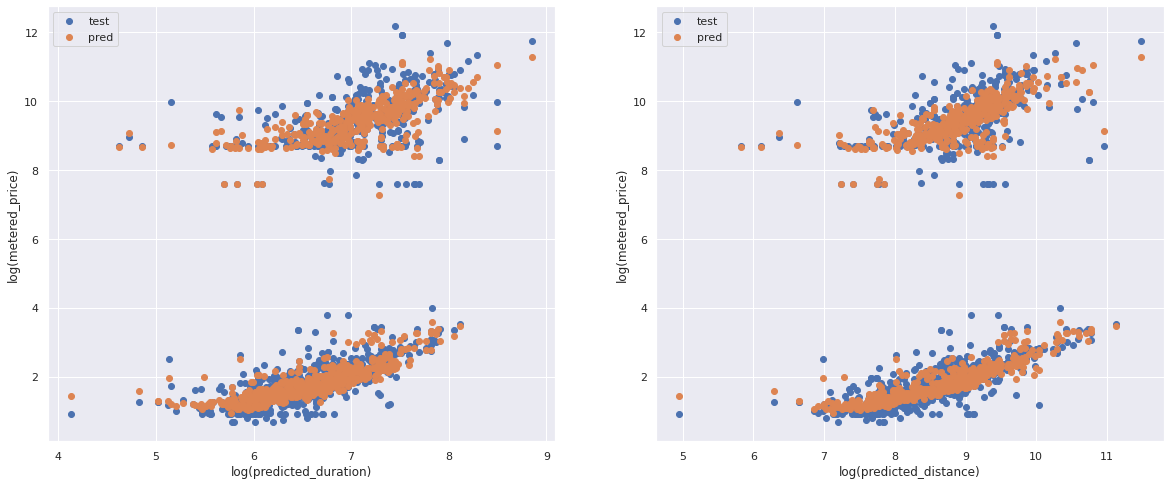

In [38]:
plot_results(X, y, y_pred)

# Random Forest

In [39]:
trips = download_dataset(DOWNLOAD_URL)
X, y = train_test_splitting.transform(trips)

In [40]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('rf', lgb.LGBMRegressor('rf', subsample=0.632, subsample_freq=1))
]
rf_pipe = Pipeline(steps)
# rf_pipe.fit(X['train'], y['train'])
# print_results(rf_pipe, X['test'], y['test'])

param_grid = {
#     'rf__bootstrap': [True],
    'rf__max_depth': [10, 20],
    'rf__n_estimators': [100, 200, 300]
}
grid_search = GridSearchCV(estimator=rf_pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X['train'], y['train'])
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X['test'])
print_results(best_grid, X['test'], y['test'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'rf__max_depth': 20, 'rf__n_estimators': 200}
R^2 = 0.98631
RMSE = 0.44910
Baseline RMSE = 0.41872


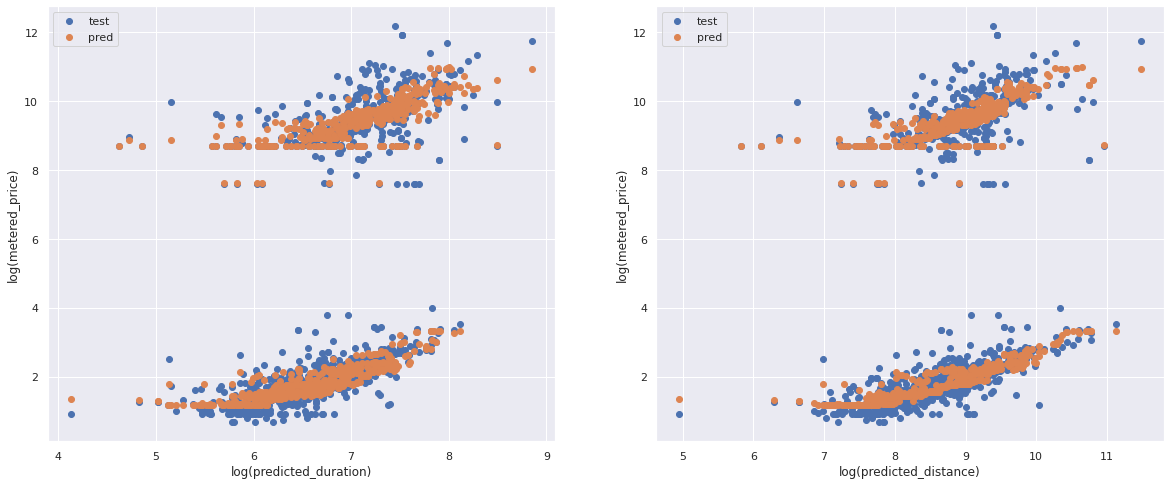

In [41]:
plot_results(X, y, y_pred)

# Neural network model

In [42]:
class TripDataset(torch.utils.data.Dataset):
    '''
    Prepare the Boston dataset for regression
    '''

    def __init__(self, X, y):
        steps = [
            ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
            ('scaler', StandardScaler())
        ]
        self.ridge_pipe = Pipeline(steps)
        self.X = self.ridge_pipe.fit_transform(X)
        self.shape = self.X.shape
        
        if not torch.is_tensor(self.X) and not torch.is_tensor(y):
            self.X = torch.from_numpy(self.X)
            self.y = torch.from_numpy(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def transform(self, X):
        transformed = self.ridge_pipe.transform(X)
        if not torch.is_tensor(transformed):
             transformed = torch.from_numpy(transformed)
        return transformed
      

class Net(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self, n_feature, n_hidden, n_output):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_feature, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 3 * n_hidden),
            nn.ReLU(),
            nn.Linear(3 * n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output),
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

    
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
    
    
def run_epoch(trainloader, net, optimizer, loss_function):
    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
        # Zero the gradients
        optimizer.zero_grad()
      
        # Perform forward pass
        outputs = net(inputs)
      
        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()
      
        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 10))
            current_loss = 0.0

In [67]:
trips = download_dataset(DOWNLOAD_URL)
X, y = train_test_splitting.transform(trips)

In [68]:
# Set fixed random number seed
torch.manual_seed(42)

train_dataset = TripDataset(X['train'], y['train'])
# dataset = TripDataset(pd.DataFrame(X_train), pd.Series(y_train))
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=1)

# Initialize the MLP
net = Net(train_dataset.shape[1], 32, 1)
# net = Net(X_train.shape[1], 16, 1)

# Define the loss function and optimizer    
loss_function = RMSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
  
# Run the training loop
for epoch in range(10):
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    run_epoch(trainloader, net, optimizer, loss_function)

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 0.531
Loss after mini-batch    11: 6.333
Loss after mini-batch    21: 6.363
Loss after mini-batch    31: 4.667
Loss after mini-batch    41: 2.615
Loss after mini-batch    51: 2.298
Loss after mini-batch    61: 1.672
Loss after mini-batch    71: 1.282
Loss after mini-batch    81: 0.985
Loss after mini-batch    91: 1.009
Loss after mini-batch   101: 1.192
Loss after mini-batch   111: 1.050
Loss after mini-batch   121: 0.899
Loss after mini-batch   131: 0.922
Loss after mini-batch   141: 0.937
Loss after mini-batch   151: 0.849
Loss after mini-batch   161: 0.695
Loss after mini-batch   171: 0.771
Loss after mini-batch   181: 0.843
Loss after mini-batch   191: 0.743
Loss after mini-batch   201: 0.553
Loss after mini-batch   211: 0.697
Loss after mini-batch   221: 0.830
Loss after mini-batch   231: 0.655
Loss after mini-batch   241: 0.864
Loss after mini-batch   251: 1.005
Loss after mini-batch   261: 0.763
Loss after mini-batch   271: 0.886
Los

Loss after mini-batch   351: 0.468
Loss after mini-batch   361: 0.459
Loss after mini-batch   371: 0.488
Loss after mini-batch   381: 0.624
Loss after mini-batch   391: 0.420
Starting epoch 7
Loss after mini-batch     1: 0.034
Loss after mini-batch    11: 0.558
Loss after mini-batch    21: 0.445
Loss after mini-batch    31: 0.452
Loss after mini-batch    41: 0.479
Loss after mini-batch    51: 0.528
Loss after mini-batch    61: 0.502
Loss after mini-batch    71: 0.442
Loss after mini-batch    81: 0.373
Loss after mini-batch    91: 0.503
Loss after mini-batch   101: 0.362
Loss after mini-batch   111: 0.558
Loss after mini-batch   121: 0.485
Loss after mini-batch   131: 0.383
Loss after mini-batch   141: 0.616
Loss after mini-batch   151: 0.500
Loss after mini-batch   161: 0.410
Loss after mini-batch   171: 0.547
Loss after mini-batch   181: 0.394
Loss after mini-batch   191: 0.502
Loss after mini-batch   201: 0.470
Loss after mini-batch   211: 0.472
Loss after mini-batch   221: 0.577
Los

In [70]:
y_pred = net(train_dataset.transform(X['test']).float()).detach().numpy().flatten()

In [76]:
R2 = 1 - sum((y['test'] - y_pred)**2) / sum((y['test'] - y['test'].mean())**2)
 
m = UPFRONT_PRICE[y['test'].index].notna()
baseline = rmse(y['test'].loc[m], UPFRONT_PRICE[y['test'].index].loc[m])

In [77]:
print('R^2 = {:.5f}\nRMSE = {:.5f}\nBaseline RMSE = {:.5f}'.format(R2, rmse(y['test'], y_pred), baseline))

R^2 = 0.97914
RMSE = 0.55437
Baseline RMSE = 0.41872


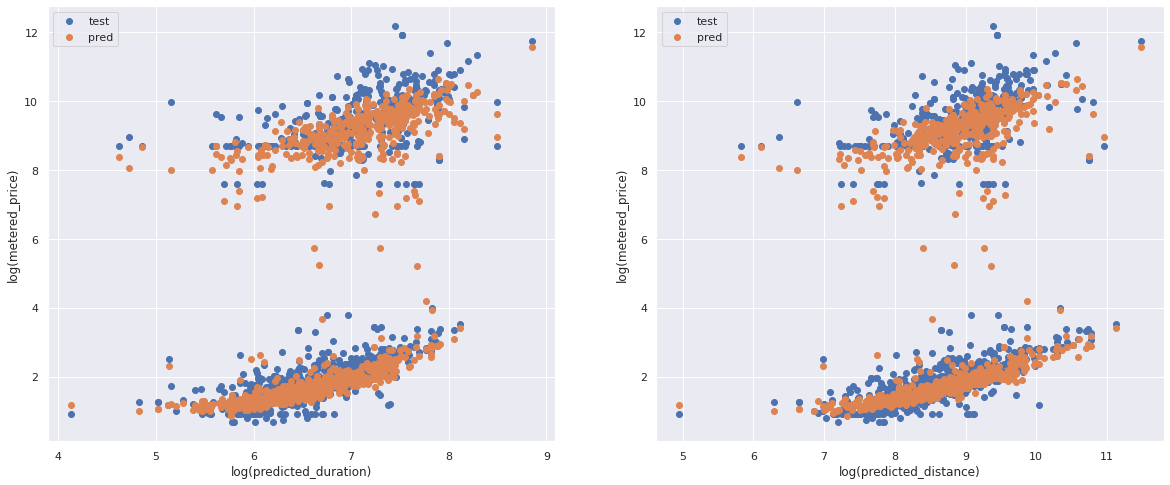

In [47]:
plot_results(X, y, y_pred)